In [1]:
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DateFormatter
import seaborn as sns
import json
import numpy as np
import pandas as pd
from swbm import seasonal_sinus
from plots import *
import os
os.chdir('..')

# Load and combine results

In [2]:
# Load best parameters from model test
with open('results/ger_test_eval.json', 'r') as file:
    ger_calib = json.load(file)

with open('results/swe_test_eval.json', 'r') as file:
    swe_calib = json.load(file)
    swe_calib[-1]['amplitude'] *= 200  # needs to be upscaled otherwise resulting B0 are way too small
    swe_calib[-1]['center'] *= 200
    swe_calib[0]['c_s'] = 420  # with the upscaled sinus parameters 420 works better than 850

with open('results/esp_test_eval.json', 'r') as file:
    esp_calib = json.load(file)

calibs = [swe_calib, ger_calib, esp_calib]

corrs = pd.DataFrame({'Correlation': list(swe_calib[2].values()) + list(ger_calib[2].values()) + list(esp_calib[2].values()),
                      'Measure': ['Soil Moisture (SM)', 'Runoff (RO)', 'ET'] * 3,
                      'Country': ['Sweden'] * 3 + ['Germany'] * 3 + ['Spain'] * 3})
np.round(corrs, 2)

,Correlation,Measure,Country
0,0.23,Soil Moisture (SM),Sweden
1,0.07,Runoff (RO),Sweden
2,0.92,ET,Sweden
3,0.90,Soil Moisture (SM),Germany
4,0.70,Runoff (RO),Germany
5,0.93,ET,Germany
6,0.91,Soil Moisture (SM),Spain
7,0.70,Runoff (RO),Spain
8,0.93,ET,Spain


In [12]:
corr_dict = {
         'Sweden': [
            swe_calib[1]['sum_corr'], 
            swe_calib[2]['sm_corr'], 
            swe_calib[2]['le_corr'], 
            swe_calib[2]['ro_corr']
            ],
         'Germany': [
            ger_calib[1]['sum_corr'],
            ger_calib[2]['sm_corr'], 
            ger_calib[2]['le_corr'], 
            ger_calib[2]['ro_corr']
            ],
         'Spain': [
            esp_calib[1]['sum_corr'], 
            esp_calib[2]['sm_corr'], 
            esp_calib[2]['le_corr'], 
            esp_calib[2]['ro_corr']
            ],
         'Correlation Type': ['sum', 'sm', 'et', 'ro']
        }
corr_df = pd.DataFrame(corr_dict)
np.round(corr_df, 2)

,Sweden,Germany,Spain,Correlation Type
0,1.22,2.53,2.53,sum
1,0.23,0.90,0.91,sm
2,0.92,0.93,0.93,et
3,0.07,0.70,0.70,ro


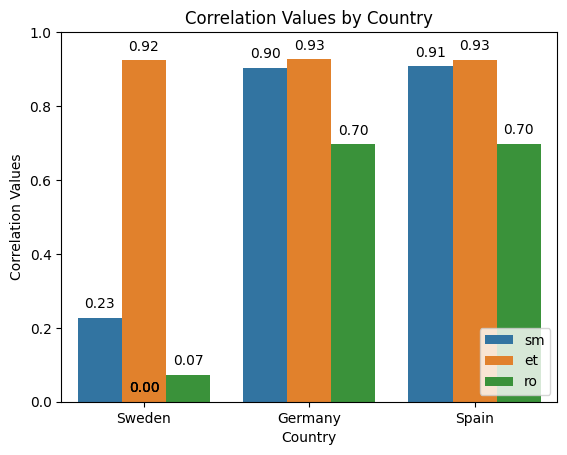

In [27]:
df_melted = corr_df.melt(id_vars='Correlation Type', var_name='Country', value_name='Correlation')

ax = sns.barplot(x='Country', y='Correlation', hue='Correlation Type', 
                 data=df_melted[df_melted['Correlation Type'] != 'sum'])

# Add annotations for all bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

ax.set_xlabel('Country')
ax.set_ylabel('Correlation Values')
ax.set_title('Correlation Values by Country')

ax.set_ylim((0, 1))
ax.legend(title=None, loc='lower right', bbox_to_anchor=(1.0, 0.0))
plt.show()

# Difference of VegSWBM to SWBM

In [28]:
# Load best parameters from model test without seasonal variation
with open('results/ger_nonseasonal_test.json', 'r') as file:
    ger_calib_non = json.load(file)

with open('results/swe_nonseasonal_test.json', 'r') as file:
    swe_calib_non = json.load(file)

with open('results/esp_nonseasonal_test.json', 'r') as file:
    esp_calib_non = json.load(file)

calibs_non = [swe_calib_non, ger_calib_non, esp_calib_non]

corrs_non = pd.DataFrame({'Correlation': list(swe_calib_non[2].values()) + list(ger_calib_non[2].values()) + list(esp_calib_non[2].values()),
                          'Measure': ['Soil Moisture (SM)', 'Runoff (RO)', 'ET'] * 3,
                          'Country': ['Sweden'] * 3 + ['Germany'] * 3 + ['Spain'] * 3})

In [29]:
# Add column with differences of VegSWBM to SWBM
corrs['Difference'] = corrs['Correlation'] - corrs_non['Correlation']
diff_data = [corrs[corrs['Country'] == 'Sweden']['Difference'], 
             corrs[corrs['Country'] == 'Germany']['Difference'], 
             corrs[corrs['Country'] == 'Spain']['Difference']]
diff_data = np.asarray(diff_data)

corrs

,Correlation,Measure,Country,Difference
0,0.226403,Soil Moisture (SM),Sweden,-0.022058
1,0.072256,Runoff (RO),Sweden,0.087581
2,0.923231,ET,Sweden,0.053395
3,0.903367,Soil Moisture (SM),Germany,0.009822
4,0.696029,Runoff (RO),Germany,-0.000067
5,0.926397,ET,Germany,0.025540
6,0.907322,Soil Moisture (SM),Spain,-0.004808
7,0.697925,Runoff (RO),Spain,-0.134796
8,0.925730,ET,Spain,0.047796


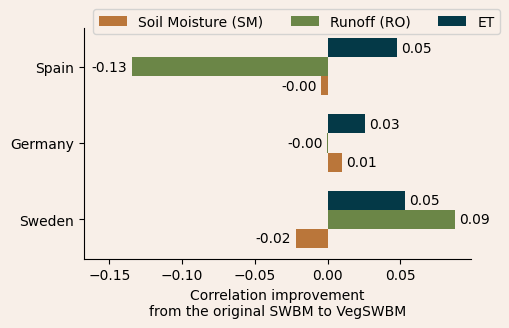

In [33]:
bar_height = 0.25

countries = ['Sweden', 'Germany', 'Spain']
corr_types = corrs['Measure'].unique()

index = np.arange(len(countries))

colors = ['#BA763A', '#6B8647', "#043947"]  # Colors for SM, RO, ET respectively

fig, ax = plt.subplots(figsize = (5, 3))
fig.set_facecolor('#F8EFE8')
for i in range(len(corr_types)):
    bars = ax.barh([y + i * bar_height for y in index],
                   [row[i] for row in diff_data], 
                   bar_height, 
                   label=corr_types[i], 
                   color=colors[i])
    for j, bar in enumerate(bars):
        width = bar.get_width()
        offset = -3 if width < 0 else 3
        ha = 'right' if width < 0 else 'left'
        ax.annotate('{:.2f}'.format(width),
                    xy=(width, bar.get_y() + bar_height / 2),
                    xytext=(offset, 0),  # 3 points horizontal offset
                    textcoords="offset points",
                    ha=ha, va='center')

xlim = ax.get_xlim()
ax.set_xlim((xlim[0] + xlim[0] * 0.15, xlim[1]))

ax.set_xlabel('Correlation improvement\nfrom the original SWBM to VegSWBM')
ax.set_yticks([y + (2 * bar_height) / 2 for y in index])
ax.set_yticklabels(countries)
legend = ax.legend(labels=['Soil Moisture (SM)', 'Runoff (RO)', 'ET'], 
loc='upper center', bbox_to_anchor=(0.55, 1.11), ncol=3)
legend.get_frame().set_facecolor('#F8EFE8')  # Set background color of the legend

# Remove top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_facecolor('#F8EFE8')

plt.savefig('figs/corr_diff_bar_h.pdf', dpi=300, bbox_inches='tight')

plt.show()

# Sinus functions for Sweden, Germany and Spain

In [34]:
sin_param = calibs[0][3]
sin_param

{'amplitude': 0.11986985335675662,
 'freq': 1.9982300430160138,
 'phase': 4.113755963808566,
 'center': 0.16618806585924106}

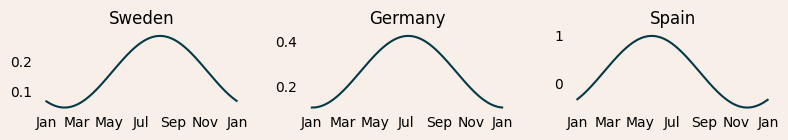

In [35]:
# Generating date range (for example, one year)
start_date = '2013-01-01'
end_date = '2013-12-31'
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

fig, axes = plt.subplots(1, 3, figsize=(8, 1.5))

# Loop through each subplot
for i, ax in enumerate(axes):
    
    # Getting sinus parameter for current subplot
    sin_param = calibs[i][3]

    # Plotting the curve
    ax.plot(date_range, seasonal_sinus(len(date_range), 
                                        amplitude=sin_param['amplitude'],
                                        freq=sin_param['freq'], 
                                        phase=sin_param['phase'], 
                                        center=sin_param['center'], 
                                        which='b0'), color='#043947')

    # Set x-axis ticks to show only every second month
    ax.xaxis.set_major_locator(MonthLocator(interval=2))
    ax.xaxis.set_major_formatter(DateFormatter('%b'))

    # Remove axis ticks
    ax.tick_params(axis='both', which='both', length=0)

    # Remove spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    ax.set_facecolor('#F8EFE8')
    fig.set_facecolor('#F8EFE8')

    # Set subplot title
    if i == 0:
        ax.set_title('Sweden')
    elif i == 1:
        ax.set_title('Germany')
    elif i == 2:
        ax.set_title('Spain')

plt.tight_layout()
plt.savefig('figs/sinus.png', bbox_inches='tight', dpi=700)
plt.show()

# Time Series: ERA5 and VegSWBM data

### Sweden

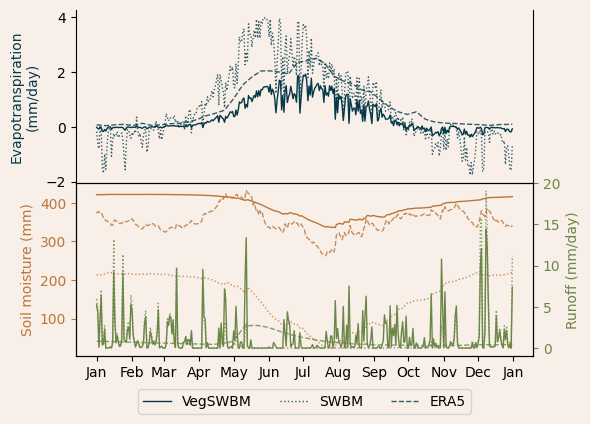

In [39]:
plt.rcParams['lines.linewidth'] = 1.0

swe_model = pd.read_csv('data/output/swe_model_test.csv')
swe_const = pd.read_csv('data/output/swe_nonseasonal_test.csv')

colors = ['#BA763A', '#6B8647', '#043947']  # sm, ro, et

year_mask = np.asarray([True if '2018' in t else False for t in swe_model['time']])

fig, ax = plt.subplots(nrows=2, figsize=(6, 4), sharex=True, gridspec_kw={'hspace': 0})

ax[0].plot(swe_model['ets_seasonal'][year_mask], color=colors[2], label='VegSWBM')
ax[0].plot(swe_const['ets'][year_mask], linestyle='dotted', color=colors[2], alpha=0.8, label='SWBM')
line, = ax[0].plot(swe_model['le'][year_mask], linestyle='dashed', color=colors[2], alpha=0.8, label='ERA5')
ax[0].set_ylabel('Evapotranspiration\n(mm/day)', color=colors[2])

# Remove x-axis spine, ticks, and labels
ax[0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax[0].set_xlabel('')  # Set an empty label to remove x-axis label
ax[0].spines['bottom'].set_visible(False)  # Remove x-axis spine
ax[0].spines['top'].set_visible(False)

ax2 = ax[1].twinx()
ax[1].plot(swe_model['moists_seasonal'][year_mask], color=colors[0])
ax[1].plot(swe_model['sm'][year_mask], color=colors[0], linestyle='dashed', alpha=0.8)
ax[1].plot(swe_const['moists'][year_mask], color=colors[0], linestyle='dotted', alpha=0.8)
ax2.plot(swe_model['runoffs_seasonal'][year_mask], color=colors[1])
ax2.plot(swe_model['ro'][year_mask], color=colors[1], linestyle='dashed', alpha=0.8)
ax2.plot(swe_const['runoffs'][year_mask], color=colors[1], linestyle='dotted', alpha=0.8)
ax2.set_ylabel('Runoff (mm/day)', color=colors[1])
ax2.yaxis.label.set_color(colors[1])
ax2.tick_params(axis='y', colors=colors[1])

ax[1].yaxis.label.set_color(colors[0])
ax[1].tick_params(axis='y', colors=colors[0])
ax[1].set_ylabel('Soil moisture (mm)')
ax[1].xaxis.set_major_locator(MonthLocator(interval=1))
ax[1].xaxis.set_major_formatter(DateFormatter('%b'))

# Custom legend handler with a different color
# legend_handler = plt.Line2D([0], [0], linestyle='dashed', color='grey', label='Observed')
legend = ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, -1.15), ncol=3)
legend.get_frame().set_facecolor('#F8EFE8')

ax[0].set_facecolor('#F8EFE8')
ax[1].set_facecolor('#F8EFE8')
fig.set_facecolor('#F8EFE8')

plt.tight_layout()

# Spain

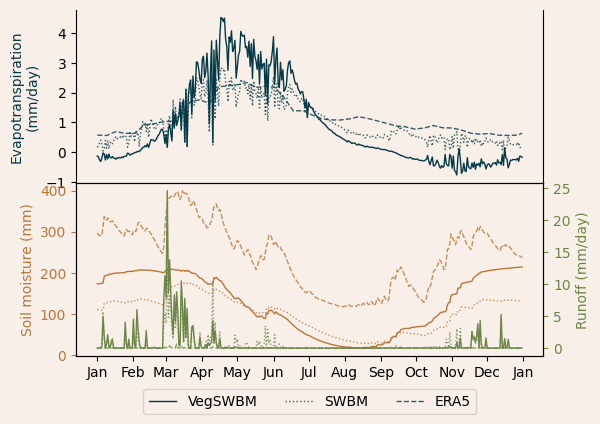

In [37]:
esp_model = pd.read_csv('data/output/esp_model_test.csv')
esp_const = pd.read_csv('data/output/esp_nonseasonal_test.csv')

fig, ax = plt.subplots(nrows=2, figsize=(6, 4), sharex=True, gridspec_kw={'hspace': 0})

ax[0].plot(esp_model['ets_seasonal'][year_mask], color=colors[2], label='VegSWBM')
ax[0].plot(esp_const['ets'][year_mask], linestyle='dotted', color=colors[2], alpha=0.8, label='SWBM')
line, = ax[0].plot(esp_model['le'][year_mask], linestyle='dashed', color=colors[2], alpha=0.8, label='ERA5')
ax[0].set_ylabel('Evapotranspiration\n(mm/day)', color=colors[2])

# Remove x-axis spine, ticks, and labels
ax[0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax[0].set_xlabel('')  # Set an empty label to remove x-axis label
ax[0].spines['bottom'].set_visible(False)  # Remove x-axis spine
ax[0].spines['top'].set_visible(False)

ax2 = ax[1].twinx()
ax[1].plot(esp_model['moists_seasonal'][year_mask], color=colors[0])
ax[1].plot(esp_model['sm'][year_mask], color=colors[0], linestyle='dashed', alpha=0.8)
ax[1].plot(esp_const['moists'][year_mask], color=colors[0], linestyle='dotted', alpha=0.8)
ax2.plot(esp_model['runoffs_seasonal'][year_mask], color=colors[1])
ax2.plot(esp_model['ro'][year_mask], color=colors[1], linestyle='dashed', alpha=0.8)
ax2.plot(esp_const['runoffs'][year_mask], color=colors[1], linestyle='dotted', alpha=0.8)
ax2.set_ylabel('Runoff (mm/day)', color=colors[1])
ax2.yaxis.label.set_color(colors[1])
ax2.tick_params(axis='y', colors=colors[1])

ax[1].yaxis.label.set_color(colors[0])
ax[1].tick_params(axis='y', colors=colors[0])
ax[1].set_ylabel('Soil moisture (mm)')
ax[1].xaxis.set_major_locator(MonthLocator(interval=1))
ax[1].xaxis.set_major_formatter(DateFormatter('%b'))

# Custom legend handler with a different color
# legend_handler = plt.Line2D([0], [0], linestyle='dashed', color='grey', label='Observed')
legend = ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, -1.15), ncol=3)
legend.get_frame().set_facecolor('#F8EFE8')

ax[0].set_facecolor('#F8EFE8')
ax[1].set_facecolor('#F8EFE8')
fig.set_facecolor('#F8EFE8')

plt.tight_layout()

# Germany

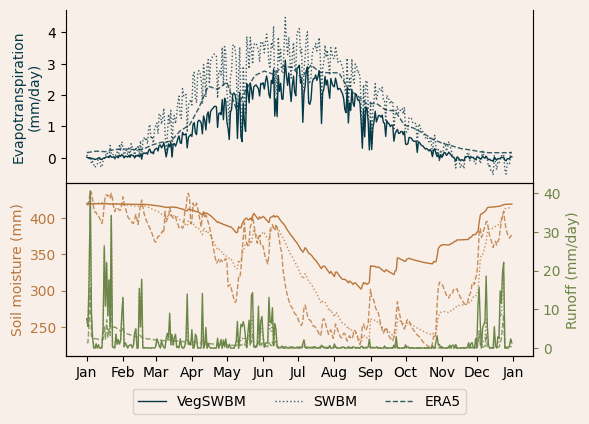

In [38]:
ger_model = pd.read_csv('data/output/ger_model_test.csv')
ger_const = pd.read_csv('data/output/ger_nonseasonal_test.csv')

fig, ax = plt.subplots(nrows=2, figsize=(6, 4), sharex=True, gridspec_kw={'hspace': 0})

ax[0].plot(ger_model['ets_seasonal'][year_mask], color=colors[2], label='VegSWBM')
ax[0].plot(ger_const['ets'][year_mask], linestyle='dotted', color=colors[2], alpha=0.8, label='SWBM')
line, = ax[0].plot(ger_model['le'][year_mask], linestyle='dashed', color=colors[2], alpha=0.8, label='ERA5')
ax[0].set_ylabel('Evapotranspiration\n(mm/day)', color=colors[2])

# Remove x-axis spine, ticks, and labels
ax[0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax[0].set_xlabel('')  # Set an empty label to remove x-axis label
ax[0].spines['bottom'].set_visible(False)  # Remove x-axis spine
ax[0].spines['top'].set_visible(False)

ax2 = ax[1].twinx()
ax[1].plot(ger_model['moists_seasonal'][year_mask], color=colors[0])
ax[1].plot(ger_model['sm'][year_mask], color=colors[0], linestyle='dashed', alpha=0.8)
ax[1].plot(ger_const['moists'][year_mask], color=colors[0], linestyle='dotted', alpha=0.8)
ax2.plot(ger_model['runoffs_seasonal'][year_mask], color=colors[1])
ax2.plot(ger_model['ro'][year_mask], color=colors[1], linestyle='dashed', alpha=0.8)
ax2.plot(ger_const['runoffs'][year_mask], color=colors[1], linestyle='dotted', alpha=0.8)
ax2.set_ylabel('Runoff (mm/day)', color=colors[1])
ax2.yaxis.label.set_color(colors[1])
ax2.tick_params(axis='y', colors=colors[1])

ax[1].yaxis.label.set_color(colors[0])
ax[1].tick_params(axis='y', colors=colors[0])
ax[1].set_ylabel('Soil moisture (mm)')
ax[1].xaxis.set_major_locator(MonthLocator(interval=1))
ax[1].xaxis.set_major_formatter(DateFormatter('%b'))

# Custom legend handler with a different color
# legend_handler = plt.Line2D([0], [0], linestyle='dashed', color='grey', label='Observed')
legend = ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, -1.15), ncol=3)
legend.get_frame().set_facecolor('#F8EFE8')

ax[0].set_facecolor('#F8EFE8')
ax[1].set_facecolor('#F8EFE8')
fig.set_facecolor('#F8EFE8')

plt.tight_layout()